## Baseline CatBoost Regression (GPU Fallback Compatible)

This notebook cell trains **two baseline CatBoost models** to predict real estate prices:

- One with **all filtered features** (low-variance features removed)
- One with **top 30 features** selected via Random Forest importance

The goal is to quickly evaluate CatBoost performance **without Optuna tuning**, while ensuring **GPU compatibility with CPU fallback**.


###  Library Imports

Includes:
- `catboost` for gradient boosting on decision trees
- `sklearn` for feature selection and evaluation
- Custom modules: 
  - `DataLoader` to load the cleaned ML dataset
  - `ModelEvaluator`, `ModelVisualizer`, `ExperimentTracker` for tracking, evaluation and plotting



### Data Preparation

- Loads the cleaned dataset via `DataLoader`
- Removes low-variance features with `VarianceThreshold`
- Uses `RandomForestRegressor` to extract the **top 30 most important features**


### Model Training with GPU Fallback

Defines a helper `train_with_fallback(...)` function that:
- Tries to train CatBoost on GPU (`task_type="GPU"`)
- If it fails (e.g., no GPU), it **automatically falls back to CPU**

Models are trained on:
- `X_reduced`: all filtered features
- `X_top`: only the top 30 features


### Model Evaluation

Each model is evaluated using:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **R<sup>2</sup>** (Coefficient of Determination)

Results are logged using `ExperimentTracker`.


### Diagnostics & Visualization

- Summary of model metrics is displayed in tables
- Diagnostic plots generated with `ModelVisualizer`:
  - Residuals
  - Prediction distribution
  - Error across price ranges
- A **side-by-side residual plot** compares both models


### Test Mode Support

If `TEST_MODE = True`:
- Dataset size and number of iterations are reduced
- Useful for debugging and fast iterations

### Summary

This cell provides a **fast, robust, GPU-aware CatBoost baseline**, ideal for:
- Comparing with tuned models (e.g., XGBoost + Optuna)
- Benchmarking preprocessing strategies
- Validating GPU/CPU execution paths


E:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TEST_MODE is ON – using reduced dataset and fewer estimators.


⏳ Training CatBoost (All Features) on GPU...


⏳ Training CatBoost (Top RF Features) on GPU...


Evaluation – CatBoost (All Features)
  MAE:  76,301.82 €
  RMSE: 109,286.49 €
  R²:   0.7264
----------------------------------------
Evaluation – CatBoost (Top RF Features)
  MAE:  76,318.95 €
  RMSE: 109,084.88 €
  R²:   0.7274
----------------------------------------
[✓] Model evaluation for 'CatBoost (All Features)' logged.
[✓] Model evaluation for 'CatBoost (Top RF Features)' logged.
Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,173,2025-06-29 15:21:32,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Linear Regression (All Features),202506291520,76 898.76 €,109 935.46 €,0.723000,Linear,8,1.430000,
1,174,2025-06-29 15:22:00,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (All Features),202506291520,68 324.02 €,101 428.25 €,0.764200,Tree,5,1.480000,
2,175,2025-06-29 15:22:09,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (Top 10 Features),202506291520,71 734.61 €,106 140.03 €,0.741800,Tree,6,1.480000,
3,176,2025-06-29 15:22:21,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (All Features) [TEST],202506291520,45 377.91 €,63 950.86 €,0.906300,Boosting,2,1.410000,
4,177,2025-06-29 15:22:21,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (Top RF Features) [TEST],202506291520,46 946.03 €,66 134.78 €,0.899800,Boosting,3,1.410000,
5,178,2025-06-29 15:23:09,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (All Features) [TEST],202506291520,48 472.19 €,68 647.33 €,0.892000,Boosting,4,1.420000,
6,179,2025-06-29 15:23:09,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291520,30 053.92 €,41 915.92 €,0.959700,Boosting,1,1.390000,✓
7,180,2025-06-29 15:23:24,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost Baseline (All Features),202506291520,76 301.82 €,109 286.49 €,0.726400,Boosting,7,1.430000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,173,2025-06-29 15:21:32,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Linear Regression (All Features),202506291520,76 898.76 €,109 935.46 €,0.723000,Linear,9,1.430000,
1,174,2025-06-29 15:22:00,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (All Features),202506291520,68 324.02 €,101 428.25 €,0.764200,Tree,5,1.480000,
2,175,2025-06-29 15:22:09,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (Top 10 Features),202506291520,71 734.61 €,106 140.03 €,0.741800,Tree,6,1.480000,
3,176,2025-06-29 15:22:21,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (All Features) [TEST],202506291520,45 377.91 €,63 950.86 €,0.906300,Boosting,2,1.410000,
4,177,2025-06-29 15:22:21,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (Top RF Features) [TEST],202506291520,46 946.03 €,66 134.78 €,0.899800,Boosting,3,1.410000,
5,178,2025-06-29 15:23:09,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (All Features) [TEST],202506291520,48 472.19 €,68 647.33 €,0.892000,Boosting,4,1.420000,
6,179,2025-06-29 15:23:09,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291520,30 053.92 €,41 915.92 €,0.959700,Boosting,1,1.390000,✓
7,180,2025-06-29 15:23:24,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost Baseline (All Features),202506291520,76 301.82 €,109 286.49 €,0.726400,Boosting,8,1.430000,
8,181,2025-06-29 15:23:24,CatBoost (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost Baseline (Top RF Features),202506291520,76 318.95 €,109 084.88 €,0.727400,Boosting,7,1.430000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Diagnostics (All Features):


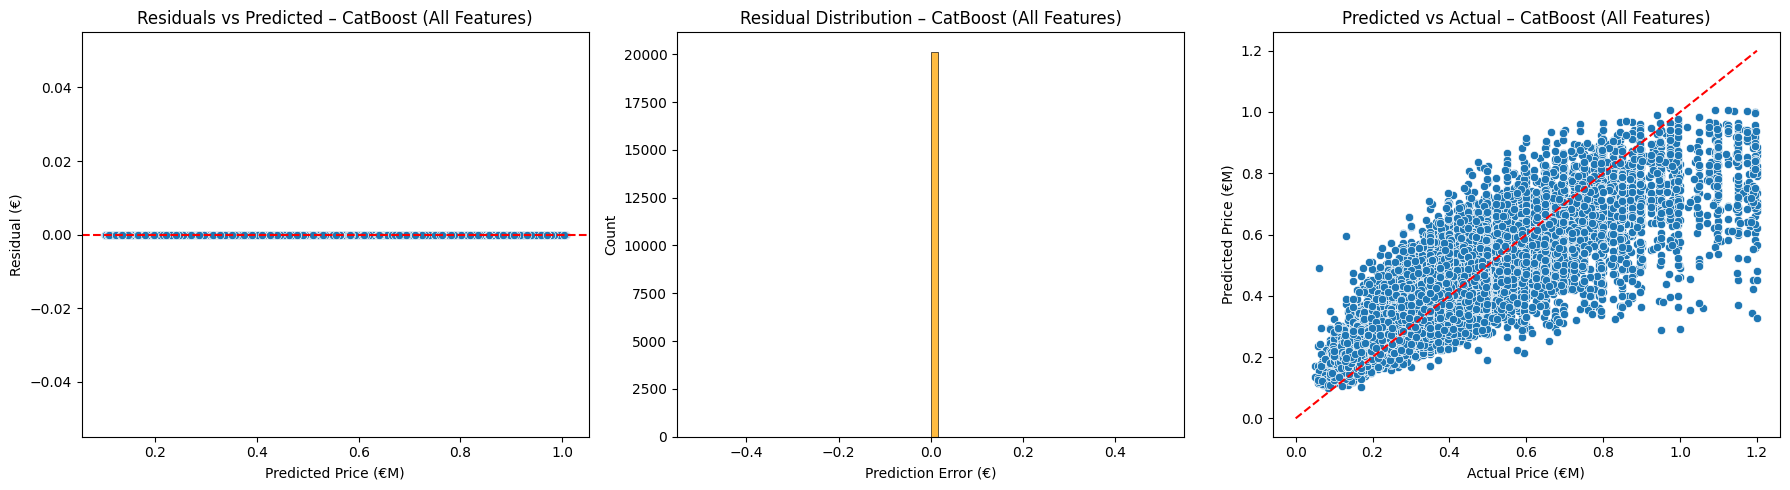

Diagnostics (Top RF Features):


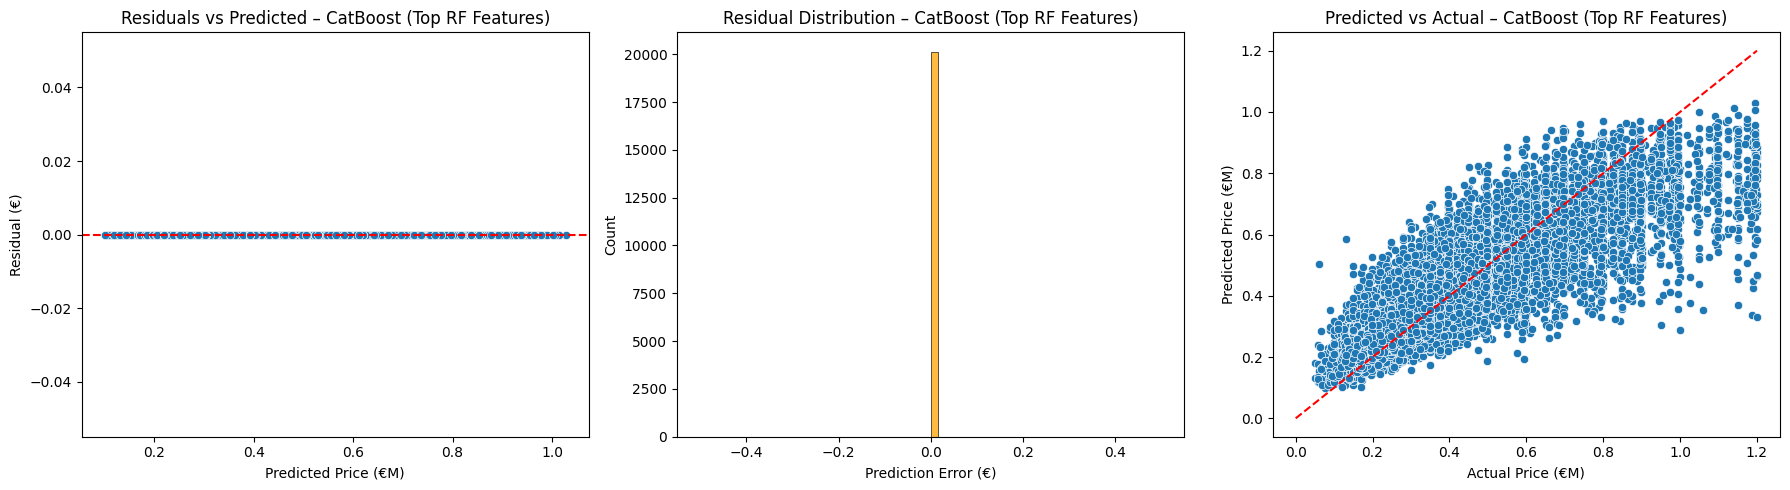

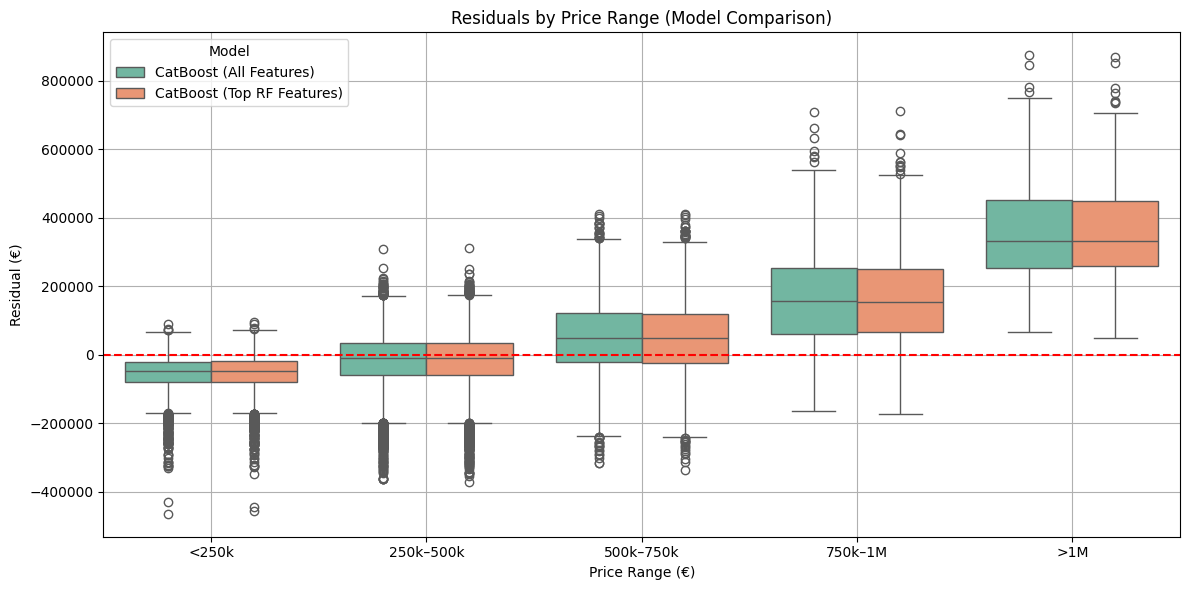

'\nOptional:\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [1]:
import sys, os
# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

if TEST_MODE:
    print("TEST_MODE is ON – using reduced dataset and fewer estimators.")
else:
    print("TEST_MODE is OFF – full training in progress.")

# Step 1: Load data
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Step 3: Extract top 30 features via RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define baseline CatBoost parameters
default_params = {
    "iterations": 500 if not TEST_MODE else 50,
    "depth": 6,
    "learning_rate": 0.1,
    "loss_function": "RMSE",
    "verbose": 0,
    "random_seed": 42
}

# Step 5: Train models with fallback logic
def train_with_fallback(X_train, y_train, model_name):
    try:
        print(f"⏳ Training {model_name} on GPU...")
        model = CatBoostRegressor(**default_params, task_type="GPU", devices="0")
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ GPU training failed for {model_name}. Falling back to CPU. Reason:\n{e}")
        model = CatBoostRegressor(**default_params, task_type="CPU")
        model.fit(X_train, y_train)
    return model

# Train on all features
model_all = train_with_fallback(X_reduced, y, "CatBoost (All Features)")
y_pred_all = model_all.predict(X_reduced)

# Train on top features
model_top = train_with_fallback(X_top, y, "CatBoost (Top RF Features)")
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluate
evaluator_all = ModelEvaluator("CatBoost (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("CatBoost (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log
tracker = ExperimentTracker()
df_metrics_all = tracker.log_and_get_evaluations(
    model="CatBoost (All Features)",
    experiment="CatBoost Baseline (All Features)",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model="CatBoost (Top RF Features)",
    experiment="CatBoost Baseline (Top RF Features)",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Summary
print("Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

# Step 9: Diagnostics
print("Diagnostics (All Features):")
ModelVisualizer(model_all, X_reduced, y, "CatBoost (All Features)").plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
ModelVisualizer(model_top, X_top, y, "CatBoost (Top RF Features)").plot_all_diagnostics()

# Step 10: Side-by-side residuals
ModelEvaluator.plot_price_range_residuals_side_by_side(
    y, y_pred_all, y_pred_top,
    model_names=("CatBoost (All Features)", "CatBoost (Top RF Features)")
)

"""
Optional:
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""


# CatBoost + Optuna Hyperparameter Tuning Pipeline


## Data Preparation

- Load the cleaned ML-ready dataset from a CSV file using `DataLoader`.
- Drop the target variable `price` to separate `X` and `y`.
- Apply `VarianceThreshold` to remove low-variance features (threshold = 0.01).
- Use a `RandomForestRegressor` to rank feature importance.
- Select the **top 30 most important features** for one of the models.


##  Hyperparameter Tuning (Optuna)

Define the function `tune_catboost_with_optuna(...)` that:

- Runs an Optuna optimization loop.
- Evaluates model performance with **5-Fold Cross-Validation**.
- Minimizes the **Root Mean Squared Error (RMSE)**.

### Tuned Hyperparameters:

- `iterations`  
- `depth`  
- `learning_rate`  
- `l2_leaf_reg`  
- `bagging_temperature`  
- `random_strength`



## Train Final Models

Two models are trained:

- One using **all filtered features**
- One using the **top 30 features**

Each is trained using the **best parameters** found by Optuna.



##  Evaluation

Models are evaluated using:

- `MAE`: Mean Absolute Error  
- `RMSE`: Root Mean Squared Error  
- `R<sup>2</sup>`: Coefficient of determination  

Results are logged with `ExperimentTracker`.



##  Diagnostics

- Summary tables displayed with `ModelEvaluator`
- Residuals & diagnostic plots from `ModelVisualizer`
- Optionally, **SHAP values** can be plotted to understand feature importance



## Test Mode (Optional)

When `TEST_MODE = True`, the pipeline uses:

- A smaller dataset  
- Fewer Optuna trials (`n_trials = 3`)  

To speed up execution and debugging.


TEST_MODE is ON – running in test mode (reduced data, fewer trials).


[I 2025-06-29 15:23:33,674] A new study created in memory with name: no-name-cbc19301-f3fd-44e2-87ef-83048601cc11


[I 2025-06-29 15:23:46,699] Trial 0 finished with value: 93019.6951778648 and parameters: {'iterations': 864, 'depth': 6, 'learning_rate': 0.2495470514069751, 'l2_leaf_reg': 3.591521533390936, 'bagging_temperature': 0.5955980387274382, 'random_strength': 0.6473193202769825}. Best is trial 0 with value: 93019.6951778648.


[I 2025-06-29 15:23:58,334] Trial 1 finished with value: 94363.13061553093 and parameters: {'iterations': 314, 'depth': 9, 'learning_rate': 0.11911278209658244, 'l2_leaf_reg': 3.6333347922841677, 'bagging_temperature': 0.30718854050158906, 'random_strength': 0.05063607539969195}. Best is trial 0 with value: 93019.6951778648.


[I 2025-06-29 15:24:21,546] Trial 2 finished with value: 94518.2522028446 and parameters: {'iterations': 934, 'depth': 8, 'learning_rate': 0.19182096644337746, 'l2_leaf_reg': 0.064846327734833, 'bagging_temperature': 0.6246293911048552, 'random_strength': 0.7573258237885285}. Best is trial 0 with value: 93019.6951778648.


[I 2025-06-29 15:24:24,172] A new study created in memory with name: no-name-0b65bf1b-dd5e-4362-a0cf-33ce396a6b94


[I 2025-06-29 15:24:33,298] Trial 0 finished with value: 95328.28032479246 and parameters: {'iterations': 812, 'depth': 5, 'learning_rate': 0.173351646266693, 'l2_leaf_reg': 0.24975568956789987, 'bagging_temperature': 0.3253517334409587, 'random_strength': 0.782018327638633}. Best is trial 0 with value: 95328.28032479246.


[I 2025-06-29 15:24:37,841] Trial 1 finished with value: 105068.8226098401 and parameters: {'iterations': 402, 'depth': 5, 'learning_rate': 0.033880804669209175, 'l2_leaf_reg': 3.422688206932856, 'bagging_temperature': 0.03179279176943506, 'random_strength': 0.8185629694510005}. Best is trial 0 with value: 95328.28032479246.


[I 2025-06-29 15:24:49,084] Trial 2 finished with value: 96136.74435583038 and parameters: {'iterations': 318, 'depth': 9, 'learning_rate': 0.20570644901013252, 'l2_leaf_reg': 3.155043580788716, 'bagging_temperature': 0.8476110304135039, 'random_strength': 0.4565083092598925}. Best is trial 0 with value: 95328.28032479246.


Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  39,978.18 €
  RMSE: 55,843.89 €
  R²:   0.9286
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  49,803.56 €
  RMSE: 70,218.23 €
  R²:   0.8870
----------------------------------------
[✓] Model evaluation for 'CatBoost + Optuna CV (All Features)' logged.
[✓] Model evaluation for 'CatBoost + Optuna CV (Top RF Features)' logged.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,173,2025-06-29 15:21:32,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Linear Regression (All Features),202506291520,76 898.76 €,109 935.46 €,0.723000,Linear,10,1.430000,
1,174,2025-06-29 15:22:00,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (All Features),202506291520,68 324.02 €,101 428.25 €,0.764200,Tree,6,1.480000,
2,175,2025-06-29 15:22:09,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (Top 10 Features),202506291520,71 734.61 €,106 140.03 €,0.741800,Tree,7,1.480000,
3,176,2025-06-29 15:22:21,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (All Features) [TEST],202506291520,45 377.91 €,63 950.86 €,0.906300,Boosting,3,1.410000,
4,177,2025-06-29 15:22:21,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (Top RF Features) [TEST],202506291520,46 946.03 €,66 134.78 €,0.899800,Boosting,4,1.410000,
5,178,2025-06-29 15:23:09,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (All Features) [TEST],202506291520,48 472.19 €,68 647.33 €,0.892000,Boosting,5,1.420000,
6,179,2025-06-29 15:23:09,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291520,30 053.92 €,41 915.92 €,0.959700,Boosting,1,1.390000,✓
7,180,2025-06-29 15:23:24,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost Baseline (All Features),202506291520,76 301.82 €,109 286.49 €,0.726400,Boosting,9,1.430000,
8,181,2025-06-29 15:23:24,CatBoost (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost Baseline (Top RF Features),202506291520,76 318.95 €,109 084.88 €,0.727400,Boosting,8,1.430000,
9,182,2025-06-29 15:24:51,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost with Optuna (All Features),202506291520,39 978.18 €,55 843.89 €,0.928600,Boosting,2,1.400000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,173,2025-06-29 15:21:32,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Linear Regression (All Features),202506291520,76 898.76 €,109 935.46 €,0.723000,Linear,11,1.430000,
1,174,2025-06-29 15:22:00,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (All Features),202506291520,68 324.02 €,101 428.25 €,0.764200,Tree,7,1.480000,
2,175,2025-06-29 15:22:09,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,Random Forest (Top 10 Features),202506291520,71 734.61 €,106 140.03 €,0.741800,Tree,8,1.480000,
3,176,2025-06-29 15:22:21,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (All Features) [TEST],202506291520,45 377.91 €,63 950.86 €,0.906300,Boosting,3,1.410000,
4,177,2025-06-29 15:22:21,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost Untuned (Top RF Features) [TEST],202506291520,46 946.03 €,66 134.78 €,0.899800,Boosting,4,1.410000,
5,178,2025-06-29 15:23:09,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (All Features) [TEST],202506291520,48 472.19 €,68 647.33 €,0.892000,Boosting,5,1.420000,
6,179,2025-06-29 15:23:09,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291520,30 053.92 €,41 915.92 €,0.959700,Boosting,1,1.390000,✓
7,180,2025-06-29 15:23:24,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost Baseline (All Features),202506291520,76 301.82 €,109 286.49 €,0.726400,Boosting,10,1.430000,
8,181,2025-06-29 15:23:24,CatBoost (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost Baseline (Top RF Features),202506291520,76 318.95 €,109 084.88 €,0.727400,Boosting,9,1.430000,
9,182,2025-06-29 15:24:51,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1520.csv,CatBoost with Optuna (All Features),202506291520,39 978.18 €,55 843.89 €,0.928600,Boosting,2,1.400000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Diagnostics (All Features):


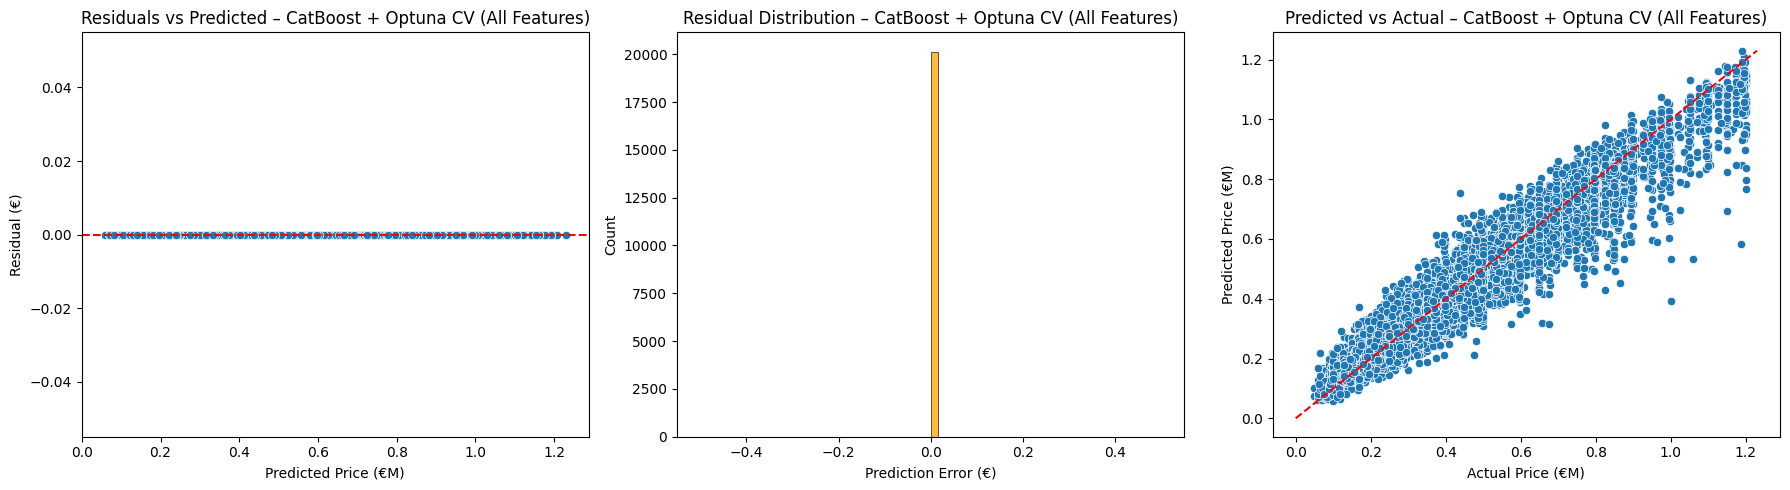

Diagnostics (Top RF Features):


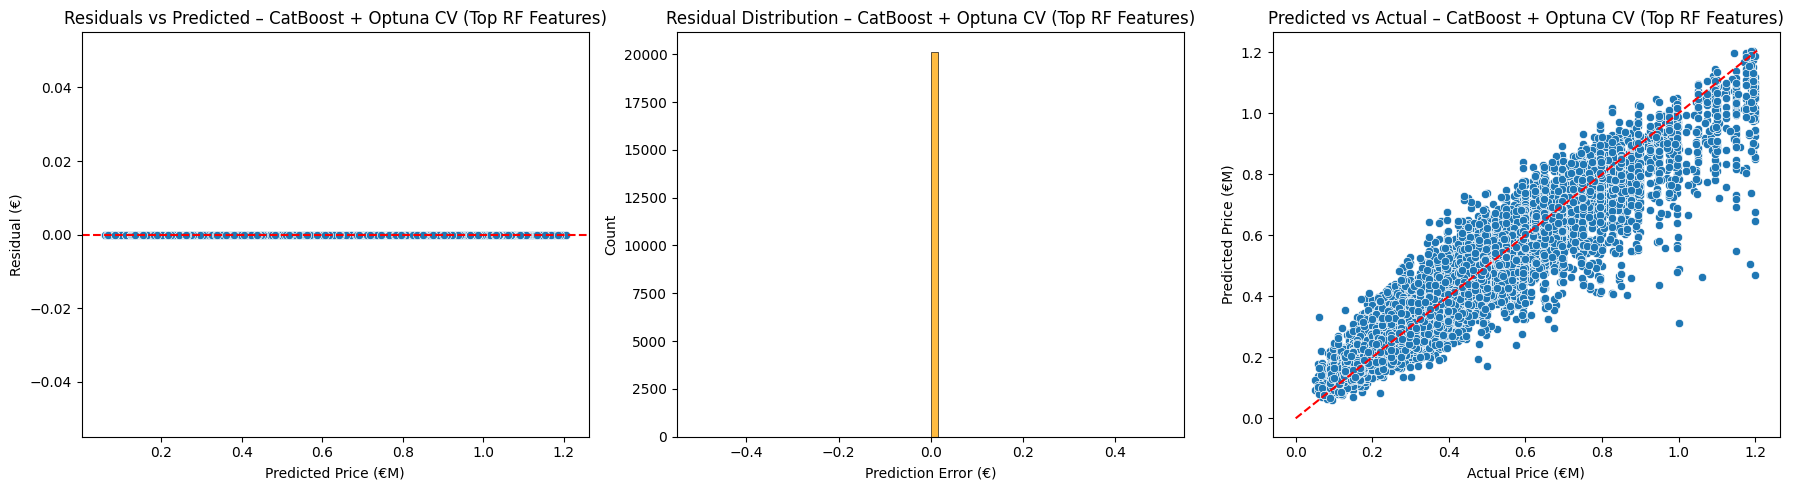

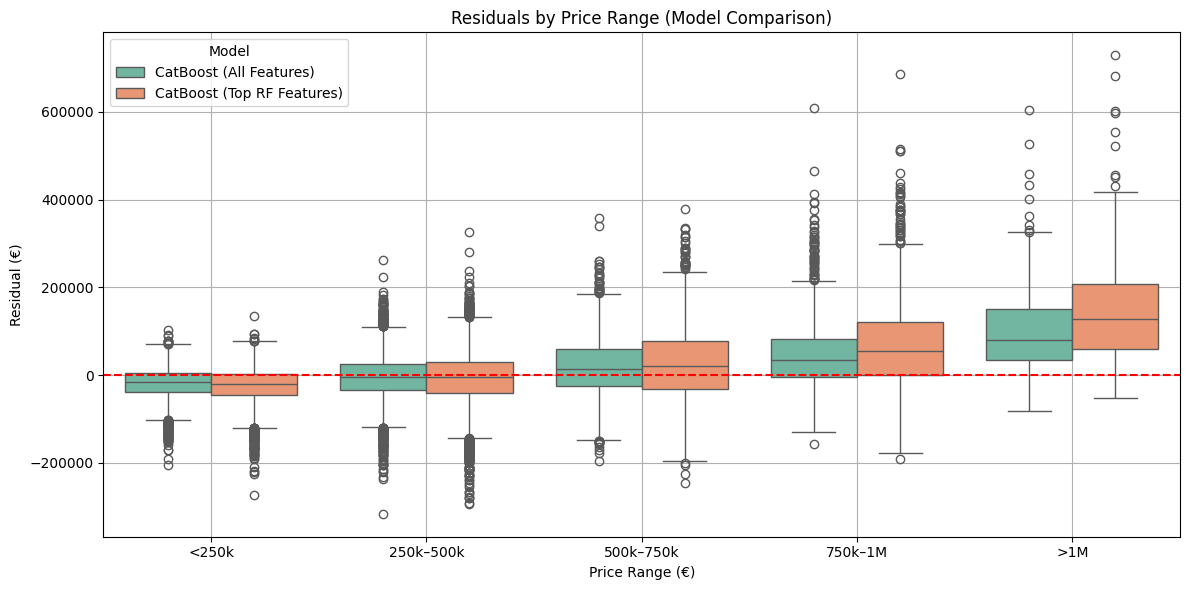

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [2]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root) 

import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
 

if TEST_MODE:
    print("TEST_MODE is ON – running in test mode (reduced data, fewer trials).")
else:
    print("TEST_MODE is OFF – full training is active.")


# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna objective for CatBoost
def tune_catboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        }

        model = CatBoostRegressor(
            **params,
            verbose=0,
            loss_function="RMSE",
            random_state=42
        )

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X_data):
            X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
            y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            scores.append(root_mean_squared_error(y_val, preds))
        return np.mean(scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

# All Features
study_all = tune_catboost_with_optuna(X_reduced, y, n_trials)
model_all = CatBoostRegressor(**study_all.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

# Top RF Features
study_top = tune_catboost_with_optuna(X_top, y, n_trials)
model_top = CatBoostRegressor(**study_top.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluation
evaluator_all = ModelEvaluator("CatBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("CatBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
tracker = ExperimentTracker()
df_metrics_all = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (All Features)",
    experiment="CatBoost with Optuna (All Features)",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (Top RF Features)",
    experiment="CatBoost with Optuna (Top RF Features)",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Summary & Diagnostics
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

print("Diagnostics (All Features):")
ModelVisualizer(model_all, X_reduced, y, "CatBoost + Optuna CV (All Features)").plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
ModelVisualizer(model_top, X_top, y, "CatBoost + Optuna CV (Top RF Features)").plot_all_diagnostics()

# Step 9: Residuals & SHAP Comparison
ModelEvaluator.plot_price_range_residuals_side_by_side(
    y, y_pred_all, y_pred_top,
    model_names=("CatBoost (All Features)", "CatBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""

In [3]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import joblib
from datetime import datetime
from utils.constants import TEST_MODE, MODELS_DIR

# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Add suffix if in TEST mode
suffix = "_TEST" if TEST_MODE else ""

# Define subdirectory for .pkl files
PKL_DIR = os.path.join(MODELS_DIR, "pkl")
if os.path.isfile(PKL_DIR):
    os.remove(PKL_DIR)  # Remove conflicting file if it exists
os.makedirs(PKL_DIR, exist_ok=True)

# Build filenames
filename_all = f"catboost_optuna_all_{timestamp}{suffix}.pkl"
filename_top = f"catboost_optuna_top30_{timestamp}{suffix}.pkl"

# Save models
joblib.dump(model_all, os.path.join(PKL_DIR, filename_all))
joblib.dump(model_top, os.path.join(PKL_DIR, filename_top))

print(f"[✔] CatBoost models saved to '{PKL_DIR}' as:\n - {filename_all}\n - {filename_top}")


[✔] CatBoost models saved to 'E:\_SoftEng\_BeCode\real-estate-price-predictor\models\pkl' as:
 - catboost_optuna_all_20250629_1524_TEST.pkl
 - catboost_optuna_top30_20250629_1524_TEST.pkl
